# UDACITY Project - [Capstone Content] Spark

In this project, we aim to predict user churn for the music streaming service Sparkify. We'll leverage a dataset of user interactions with Sparkify’s app to develop a model capable of identifying users at risk of cancellation.

# Table of Contents

1. [Import Libraries & Spark Session Preparation](#1-import-libraries--spark-session-preparation)
2. [Data Exploration](#2-data-exploration)
3. [Data Preparation & Cleanup](#3-data-preparation--cleanup)
4. [Feature Engineering](#4-feature-engineering)
5. [Modeling](#5-modeling)

# 1. Import Libraries & Spark Session Preparation
In this section, we will import the necessary libraries and create a Spark session to load and process the Sparkify dataset.

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, trim, min, max, split, udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
#from pyspark.sql.functions import desc
#from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
#from pyspark.sql.functions import when, col
from functools import reduce
from pyspark.sql import functions as F
from IPython.display import Markdown

from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import re

#import ibmos2spark

In [2]:
## Starter code
from pyspark.sql import SparkSession

## Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Read in full sparkify dataset
event_data = "./data/mini_sparkify_event_data.json"
user_log = spark.read.json(event_data)
user_log.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

# 2. Data Exploration
Before diving into data cleaning and feature engineering, we’ll explore the dataset to understand its structure, the types of features available, and basic statistics.

The df contains user interaction data from Sparkify, detailing user demographics, session activities, song plays, subscription status, and technical details of each interaction within the application.

In [3]:
df = user_log.toPandas()
print(df.shape)

(286500, 18)


### Column Descriptions
The dataset contains various columns detailing user interactions. Here’s a summary of each column to provide context on the data we'll work with.

1. **`artist`**: The name of the musical artist associated with the song that the user listened to or interacted with.
2. **`auth`**: The authentication status of the user at the time of interaction, such as "Logged In" or other states indicating if the user was authenticated.
3. **`firstName`**: The first name of the user interacting with the service.
4. **`gender`**: The gender of the user, represented as "M" for male and "F" for female.
5. **`itemInSession`**: Indicates the sequence or order of interactions within a single session, often reflecting the nth interaction by the user in that session.
6. **`lastName`**: The last name of the user.
7. **`length`**: The length of the song or media in seconds, representing the duration of the content the user interacted with.
8. **`level`**: The subscription level of the user, shown as "free" or "paid".
9. **`location`**: The geographical location of the user, given as "City, State".
10. **`method`**: The HTTP method used for the interaction, such as "PUT" or "GET", indicating the type of request.
11. **`page`**: The page or action the user accessed within the application, such as "NextSong" which indicates that the user played the next song.
12. **`registration`**: The timestamp of the user's registration on the platform, represented in epoch format.
13. **`sessionId`**: A unique identifier for the user's session, allowing tracking of all actions within a specific session.
14. **`song`**: The title of the song or media item the user listened to.
15. **`status`**: The HTTP status code resulting from the user's action, where "200" indicates a successful request.
16. **`ts`**: The timestamp of the specific user interaction, recorded in epoch format.
17. **`userAgent`**:: The user's device and browser information, providing details on the operating system, browser, and version.
18. **`userId`**: A unique identifier assigned to the user for tracking purposes across sessions.


In [4]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
distinct_pages = user_log.select("page").distinct()
distinct_pages.show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



The status column refers to the HTML status of the entry. Three posible statuses are tracked in the list, namely 200, 307 and 404. The meanings are listed in the following:
- 307: Temporary Redirect: The request should be repeated with another URI, but future requests should use the original URI.
- 404: Not Found: The requested resource couldn’t be found on the server.
- 200 OK: The request succeeded, and the server returned the requested resource.

In [6]:
# HTML status codes 
distinct_pages = user_log.groupBy("status").count().orderBy(desc('count'))
distinct_pages.show(50)

+------+------+
|status| count|
+------+------+
|   200|259812|
|   307| 26430|
|   404|   258|
+------+------+



### Visualizing User Activity
We'll create visualizations of user interactions, top songs, top artists, and activity distributions to gain further insight into user behavior on the platform.

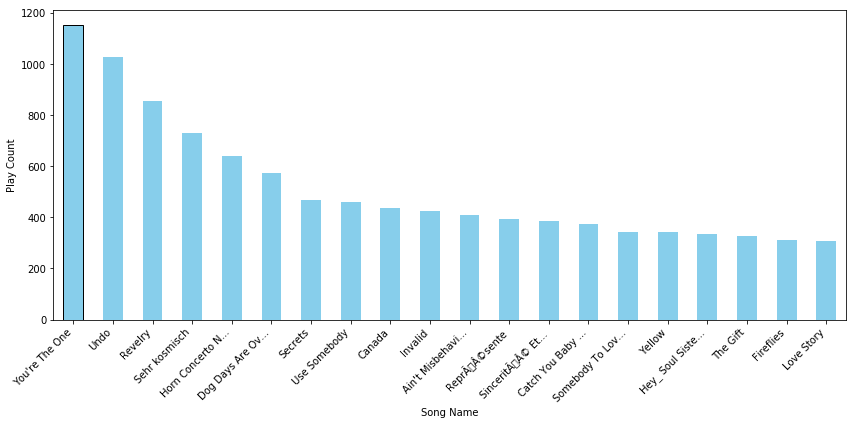

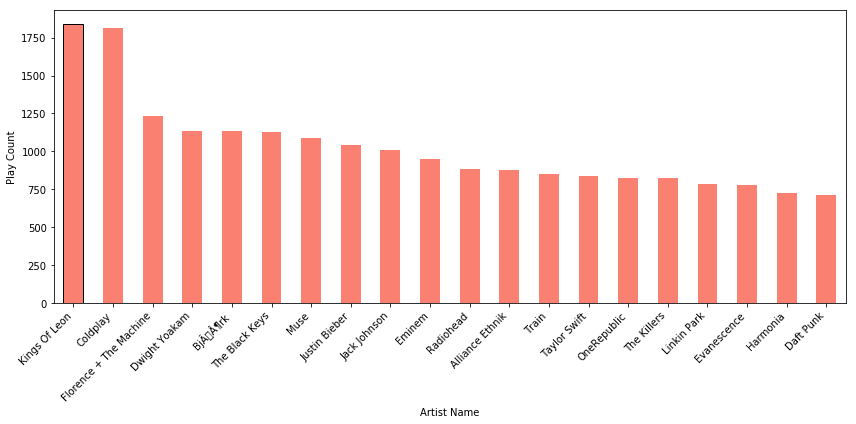

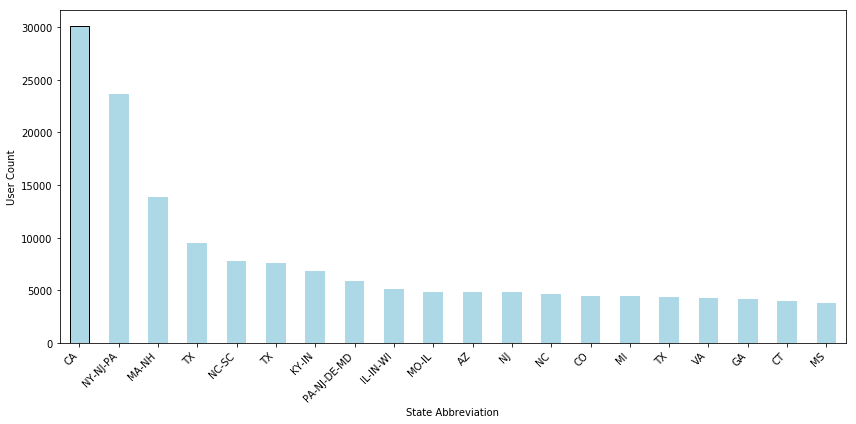

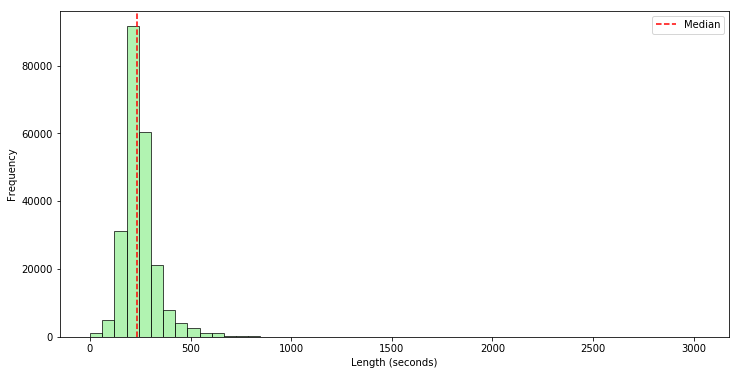

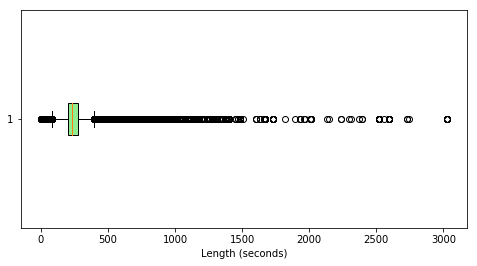

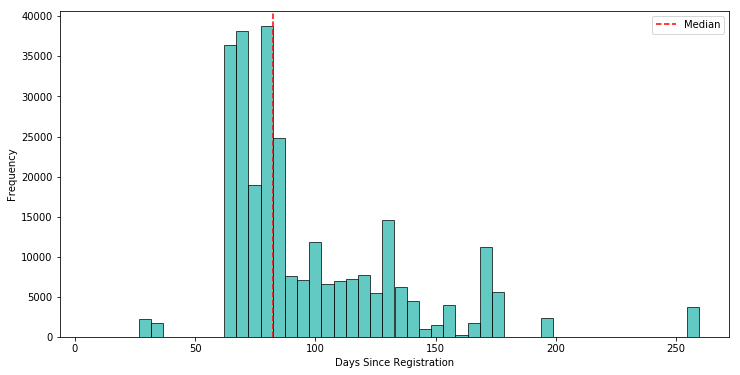

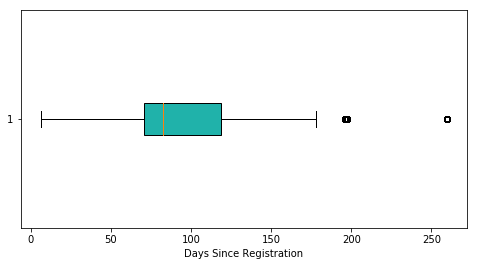

In [7]:
import matplotlib.pyplot as plt

# Set the number of top songs, artists, and locations to display for better readability
top_n = 20

# Calculate the top N songs, artists, and locations based on play or interaction counts
top_songs = df['song'].value_counts().head(top_n)
top_artists = df['artist'].value_counts().head(top_n)
top_locations = df['location'].value_counts().head(top_n)

# Truncate long song names for better readability
def truncate_label(label, max_length=15):
    return label if len(label) <= max_length else label[:max_length] + "..."

# Extract state abbreviation from location
def get_state_abbr(location):
    # Split the location string and take the last part as the state abbreviation
    return location.split(",")[-1].strip()

# Apply the truncation and state abbreviation functions
top_songs.index = [truncate_label(song) for song in top_songs.index]
top_locations.index = [get_state_abbr(location) for location in top_locations.index]

# Plotting the top N songs by play count
plt.figure(figsize=(12, 6))
top_songs.plot(kind='bar', color='skyblue', edgecolor='black', linewidth=1)
plt.xlabel("Song Name")
plt.ylabel("Play Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the top N artists by play count
plt.figure(figsize=(12, 6))
top_artists.plot(kind='bar', color='salmon', edgecolor='black', linewidth=1)
plt.xlabel("Artist Name")
plt.ylabel("Play Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the top N locations by user count
plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar', color='lightblue', edgecolor='black', linewidth=1)
plt.xlabel("State Abbreviation")
plt.ylabel("User Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the distribution of song lengths with median line and histogram
plt.figure(figsize=(12, 6))
plt.hist(df['length'].dropna(), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(df['length'].dropna().median(), color='red', linestyle='--', linewidth=1.5, label='Median')
plt.xlabel("Length (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Box plot for song lengths to highlight range, interquartile range, and outliers
plt.figure(figsize=(8, 4))
plt.boxplot(df['length'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.xlabel("Length (seconds)")
plt.show()

# Calculating registration time in days from the most recent interaction
df['t_reg_days'] = ((df['ts'].max() - df['registration']) / (1000 * 3600 * 24)).round(5)

# Plotting the distribution of registration times in days with a median line
plt.figure(figsize=(12, 6))
plt.hist(df['t_reg_days'].dropna(), bins=50, color='lightseagreen', edgecolor='black', alpha=0.7)
plt.axvline(df['t_reg_days'].median(), color='red', linestyle='--', linewidth=1.5, label='Median')
plt.xlabel("Days Since Registration")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Box plot for registration times in days to examine spread and outliers
plt.figure(figsize=(8, 4))
plt.boxplot(df['t_reg_days'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightseagreen'))
plt.xlabel("Days Since Registration")
plt.show()

# 3. Data Preparation & Cleanup
Next, we will clean the dataset by identifying and handling null values. This step ensures our dataset is well-prepared for feature engineering and modeling.

### Checking for Null Values
We’ll identify columns with null values and assess their impact. In some cases, we’ll selectively drop or impute these values based on their relevance to user churn prediction.

In [8]:
# Get number of rows
num_rows = user_log.count()

# Get number of columns
num_columns = len(user_log.columns)

# Print the shape 
print(f"The shape of the df is: ({num_rows}, {num_columns})")

The shape of the df is: (286500, 18)


In [9]:
# Count the number of null values in each column
null_counts = user_log.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in user_log.columns])
null_counts.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# Checking for pages with NaN-values that are song-related
user_log = user_log.withColumn('song_nan',F.col('song').isNull())
user_log.groupBy('page', 'song_nan').count().orderBy(desc('count')).show(50)

+--------------------+--------+------+
|                page|song_nan| count|
+--------------------+--------+------+
|            NextSong|   false|228108|
|                Home|    true| 14457|
|           Thumbs Up|    true| 12551|
|     Add to Playlist|    true|  6526|
|          Add Friend|    true|  4277|
|         Roll Advert|    true|  3933|
|               Login|    true|  3241|
|              Logout|    true|  3226|
|         Thumbs Down|    true|  2546|
|           Downgrade|    true|  2055|
|                Help|    true|  1726|
|            Settings|    true|  1514|
|               About|    true|   924|
|             Upgrade|    true|   499|
|       Save Settings|    true|   310|
|               Error|    true|   258|
|      Submit Upgrade|    true|   159|
|    Submit Downgrade|    true|    63|
|              Cancel|    true|    52|
|Cancellation Conf...|    true|    52|
|            Register|    true|    18|
| Submit Registration|    true|     5|
+--------------------+---

The evaluation above shows that NaN-values only exist for songs where page = NextSong

In [11]:
# Checking for pages with NaN-values that are user-related
user_log = user_log.withColumn('user_nan',F.col('firstName').isNull())
user_log.groupBy('page', 'user_nan').count().orderBy(desc('count')).show(50)

+--------------------+--------+------+
|                page|user_nan| count|
+--------------------+--------+------+
|            NextSong|   false|228108|
|           Thumbs Up|   false| 12551|
|                Home|   false| 10082|
|     Add to Playlist|   false|  6526|
|                Home|    true|  4375|
|          Add Friend|   false|  4277|
|         Roll Advert|   false|  3933|
|               Login|    true|  3241|
|              Logout|   false|  3226|
|         Thumbs Down|   false|  2546|
|           Downgrade|   false|  2055|
|            Settings|   false|  1514|
|                Help|   false|  1454|
|             Upgrade|   false|   499|
|               About|   false|   495|
|               About|    true|   429|
|       Save Settings|   false|   310|
|                Help|    true|   272|
|               Error|   false|   252|
|      Submit Upgrade|   false|   159|
|    Submit Downgrade|   false|    63|
|Cancellation Conf...|   false|    52|
|              Cancel|   

Let us exclusively drop the user-related null-value as the model shall be a user-based churn model.

In [12]:
user_log = user_log.na.drop(subset=['firstName'])

In [13]:
# Count the number of null values after dropping the user-related null values
null_counts = user_log.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in user_log.columns])
null_counts.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+--------+--------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|song_nan|user_nan|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+--------+--------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|       0|       0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+--------+--------+



# 4. Feature Engineering
In this section, we create new features that could be useful in predicting churn. Features will be derived from user characteristics, account details, and activity metrics.

In [14]:
user_log.createOrReplaceTempView('user_log')

Let us check how many distinct users we have in our dataset:

In [15]:
n_users = user_log.select('userId').distinct().count()
n_users

225

### Defining Churn
To predict churn, we need a clear definition of what churn represents in this context. Here, we define churn as users who have interacted with the “Cancellation Confirmation” page.

In [16]:
# Difinition of churn
cancel_conf = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = user_log.withColumn("churn", cancel_conf("page"))\
    .select(["userId", "churn"])\
    .groupBy("userId").agg(max("churn").alias("churn"))

churn_rate = round(churn.select(avg('churn')).collect()[0]['avg(churn)']*100, 2)
print(f"The churn-rate is {churn_rate}%.")
churn.show(3)

The churn-rate is 23.11%.
+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
+------+-----+
only showing top 3 rows



In addition to the churn, which will be the variable we want to predict, we want to include various features. A summary of the features is given in the following:

#### 1. User Related Features
    1.1 Gender
    (1.2 Location)
    (1.3 Browser/Computer)
    
#### 2. Account Related Features
    2.1 Time Since Registration
    2.2 Subscription Frequency
    2.3 Unsubscription Frequency
    2.4 Average Time on Paid Subscription
    2.5 Average Time on Free Subscription

#### 3. Song Related Features
    3.1 Number of Unique Artists
    3.2 Overall Average Items per Session
    3.3 Number of Sessions
    3.4 Total Number of Songs Played
    3.5 Number of Unique Songs
    3.6 Total Thumbs Up Count
    3.7 Total Thumbs Down Count
    3.8 Total Length of Songs Played
    
#### 4. Plattform Related Features
    4.1 Total Number of Events
    4.2 Number of Client errors (Error 404)

In the following, the calculation of the various features is presented. We’ll create features based on user characteristics, including gender, time since registration, and subscription level. These features could help our model distinguish churned users from active ones.

#### 1. Creating User-Related Features

In [17]:
# User related features
user_related = spark.sql(
    '''
    SELECT userId, 
        AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender_num
    FROM user_log
    GROUP BY userId
    '''
)

user_related.show(3)

+------+----------+
|userId|gender_num|
+------+----------+
|100010|       0.0|
|200002|       1.0|
|   125|       1.0|
+------+----------+
only showing top 3 rows



#### 2. Creating Account Related Features

In [18]:
# Acount Related Features
account_related = spark.sql(
    '''
    SELECT userId,
        ROUND((MAX(ts) - MAX(registration))/(1000*3600*24),5) t_reg_days,
        AVG(CASE WHEN level = "paid" THEN 1 ELSE 0 END) level
    FROM user_log
    GROUP BY userId
    '''
)

account_related.show(3)

+------+----------+------------------+
|userId|t_reg_days|             level|
+------+----------+------------------+
|100010|  55.64366|               0.0|
|200002|  70.07463|0.7468354430379747|
|   125|  71.31689|               0.0|
+------+----------+------------------+
only showing top 3 rows



#### 3. Song Related Features

In [19]:
# Song Related Features
song_related = spark.sql(
    '''
    SELECT userId,
        COUNT(DISTINCT artist) n_artists,
        AVG(itemInSession) avg_ItemInSession,
        COUNT(DISTINCT sessionId) n_sessions,
        COUNT(song) n_songs, 
        COUNT(DISTINCT song) n_songs_unique,
        SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) n_thumbs_up,
        SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) n_thumbs_down,
        ROUND(SUM(length)) as length_tot
    FROM user_log
    GROUP BY userId
    '''
)

song_related.show(3)

+------+---------+-----------------+----------+-------+--------------+-----------+-------------+----------+
|userId|n_artists|avg_ItemInSession|n_sessions|n_songs|n_songs_unique|n_thumbs_up|n_thumbs_down|length_tot|
+------+---------+-----------------+----------+-------+--------------+-----------+-------------+----------+
|100010|      252|35.89501312335958|         7|    275|           269|         17|            5|   66941.0|
|200002|      339|60.57805907172996|         6|    387|           378|         21|            6|   94009.0|
|   125|        8|              5.0|         1|      8|             8|          0|            0|    2089.0|
+------+---------+-----------------+----------+-------+--------------+-----------+-------------+----------+
only showing top 3 rows



#### 4. Plattform Related Features

In [20]:
# Plattform Related Features
plattform_related = spark.sql(
    '''
    SELECT userId,
        COUNT(page) n_events,
        SUM(CASE WHEN status = "404" THEN 1 ELSE 0 END) n_error_404
    FROM user_log
    GROUP BY userId
    '''
)

plattform_related.show(3)

+------+--------+-----------+
|userId|n_events|n_error_404|
+------+--------+-----------+
|100010|     381|          0|
|200002|     474|          0|
|   125|      11|          0|
+------+--------+-----------+
only showing top 3 rows



In [21]:
# Number of errors per user
plattform_related.select("userId", "n_error_404").orderBy("n_error_404", ascending=False).show(5)

+------+-----------+
|userId|n_error_404|
+------+-----------+
|    42|          7|
|   140|          7|
|    39|          7|
|   124|          6|
|   142|          5|
+------+-----------+
only showing top 5 rows



#### Join columns to final dataset df

In [22]:
df = churn.join(user_related, ['userId'])\
    .join(account_related, ['userId'])\
    .join(song_related, ['userId'])\
    .join(plattform_related, ['userId'])

df.head()

Row(userId='100010', churn=0, gender_num=0.0, t_reg_days=55.64366, level=0.0, n_artists=252, avg_ItemInSession=35.89501312335958, n_sessions=7, n_songs=275, n_songs_unique=269, n_thumbs_up=17, n_thumbs_down=5, length_tot=66941.0, n_events=381, n_error_404=0)

In [23]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender_num: double (nullable = true)
 |-- t_reg_days: double (nullable = true)
 |-- level: double (nullable = true)
 |-- n_artists: long (nullable = false)
 |-- avg_ItemInSession: double (nullable = true)
 |-- n_sessions: long (nullable = false)
 |-- n_songs: long (nullable = false)
 |-- n_songs_unique: long (nullable = false)
 |-- n_thumbs_up: long (nullable = true)
 |-- n_thumbs_down: long (nullable = true)
 |-- length_tot: double (nullable = true)
 |-- n_events: long (nullable = false)
 |-- n_error_404: long (nullable = true)



In [24]:
df.toPandas().head()

,userId,churn,gender_num,t_reg_days,level,n_artists,avg_ItemInSession,n_sessions,n_songs,n_songs_unique,n_thumbs_up,n_thumbs_down,length_tot,n_events,n_error_404
0,100010,0,0.0,55.64366,0.000000,252,35.895013,7,275,269,17,5,66941.0,381,0
1,200002,0,1.0,70.07463,0.746835,339,60.578059,6,387,378,21,6,94009.0,474,0
2,125,1,1.0,71.31689,0.000000,8,5.000000,1,8,8,0,0,2089.0,11,0
3,124,0,0.0,131.55591,1.000000,2232,165.099275,29,4079,3339,171,41,1012312.0,4825,6
4,51,1,1.0,19.45584,1.000000,1385,200.603490,10,2111,1854,100,21,523276.0,2464,1


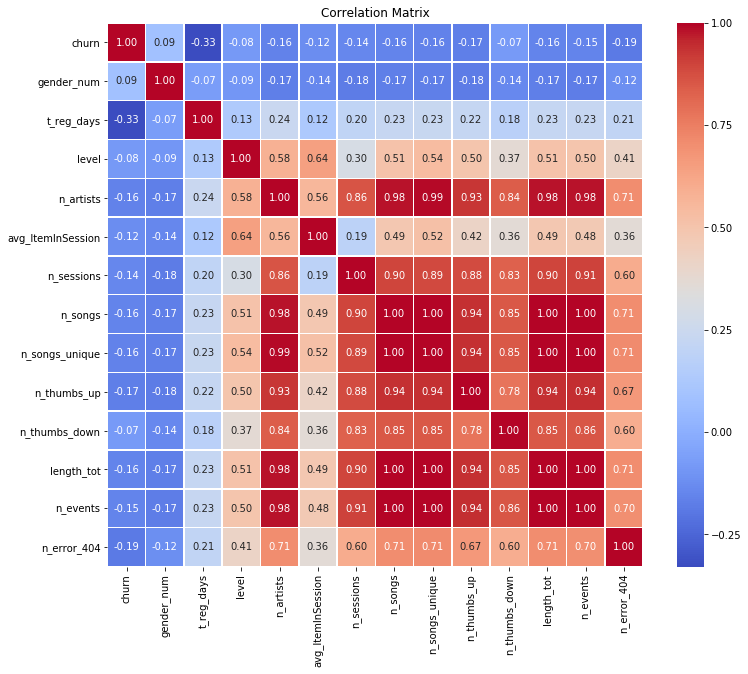

In [25]:
# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Calculate correlation matrix
corr_matrix = df_pd.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


The song_related features show strong correlation, meaning that there is some potential for dimensionality reduction. This shall be done using Principal Component Analysis (PCA), implemented in the pipeline in the following modeling section.

# 5. Modeling
With the features engineered, we can now proceed to model building. We’ll split the data into training and test sets, and experiment with different algorithms to find the best predictive model.

In [36]:
# Split the data into train and test data
train, test = df.randomSplit([0.8, 0.2], seed=49)

In [37]:
# Rename the target column to "label"
train = train.withColumnRenamed("churn", "label")
test = test.withColumnRenamed("churn", "label")

In [39]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="inputFeatures")

In [40]:
scaler = Normalizer(inputCol="inputFeatures", outputCol="scaled_features")

In [41]:
pca = PCA(k=3, inputCol="scaled_features", outputCol="features")

### Model Selection
We’ll implement multiple machine learning models, including Logistic Regression, Random Forest, and Gradient-Boosted Trees, and evaluate each model’s performance using cross-validation.


In [42]:
# Logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline_lr = Pipeline(stages=[assembler, scaler, pca, lr])

# Random forest classifier
rf = RandomForestClassifier() 
pipeline_rf  = Pipeline(stages=[assembler, scaler, pca, rf])

# Gradient-boosted tree classifier
gbt = GBTClassifier() 
pipeline_gbt = Pipeline(stages=[assembler, scaler, pca, gbt])

# Models
models = [
    ("logistic_regression", lr, pipeline_lr),
    ("random_forest", rf, pipeline_rf),
    ("gradient_boosted_trees", gbt, pipeline_gbt)
]

### Parameter Tuning
To optimize model performance, we’ll use cross-validation and grid search to fine-tune hyperparameters for our models, trying to maximize accuracy while minimizing overfitting.


In [43]:
paramgrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.1])\
    .addGrid(lr.maxIter, [10])\
    .build()


evaluator=MulticlassClassificationEvaluator(metricName="f1")

In [44]:
for model_name, model, pipeline in models:
    print(f"Training {model_name} model...")
    
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramgrid,
                              evaluator=evaluator,
                              numFolds=3)
    t_start = time.time()
    cvModel = crossval.fit(train)
    t_end = time.time()
    print(f"The {model_name} cross-validation model fitting process took {(t_end - t_start):.2f}s.")

    print(f"Saving {model_name} model...")
    # Save the best model from cross-validation
    bestModel = cvModel.bestModel
    bestModel.write().overwrite().save(f"{model_name}_model")
    print("Model saved successfully!")

Training logistic_regression model...
The logistic_regression cross-validation model fitting process took 1634.97s.
Saving logistic_regression model...
Model saved successfully!
Training random_forest model...
The random_forest cross-validation model fitting process took 853.48s.
Saving random_forest model...
Model saved successfully!
Training gradient_boosted_trees model...
The gradient_boosted_trees cross-validation model fitting process took 3277.28s.
Saving gradient_boosted_trees model...
Model saved successfully!


# 6. Evaluation & Results
After training, we’ll evaluate the model on the test data, calculate key metrics, and assess the model’s overall accuracy and F1 score to determine its effectiveness in predicting churn.

In [47]:
model_stats = {}

for model_name, _, _ in models:
    print(f"Evaluating {model_name} model...")
    
    # Load model
    model = PipelineModel.load(f"{model_name}_model")
    
    # Transform test data to get predictions
    predictions = model.transform(test)

    # Calculate metrics on `test` predictions
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    # Print the metrics
    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Precision for {model_name}: {precision:.4f}")
    print(f"Recall for {model_name}: {recall:.4f}")
    print(f"F1-Score for {model_name}: {f1:.4f}")
    print("\n")
    
    # Save metrics for model
    model_stats[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

Evaluating logistic_regression model...
Accuracy for logistic_regression: 0.7143
Precision for logistic_regression: 0.5102
Recall for logistic_regression: 0.7143
F1-Score for logistic_regression: 0.5952


Evaluating random_forest model...
Accuracy for random_forest: 0.7619
Precision for random_forest: 0.8214
Recall for random_forest: 0.7619
F1-Score for random_forest: 0.6939


Evaluating gradient_boosted_trees model...
Accuracy for gradient_boosted_trees: 0.7381
Precision for gradient_boosted_trees: 0.7216
Recall for gradient_boosted_trees: 0.7381
F1-Score for gradient_boosted_trees: 0.6766




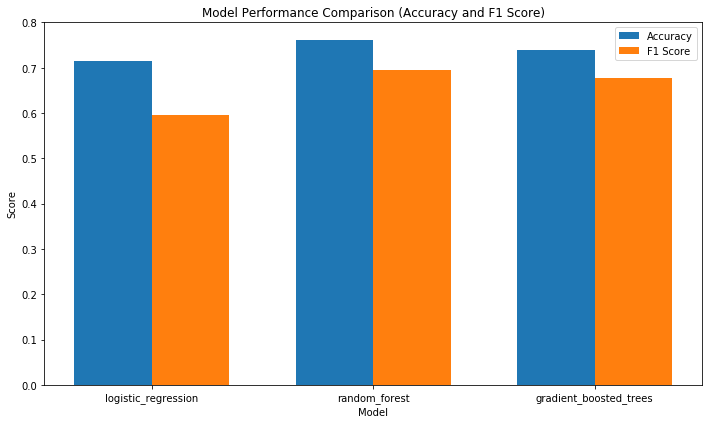

In [51]:
# Plotting accuracies and f1-scores
model_names = list(model_stats.keys())
accuracies = [model_stats[model]['Accuracy'] for model in model_names]
f1_scores = [model_stats[model]['F1 Score'] for model in model_names]

bar_width = 0.35
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(index, accuracies, bar_width, label='Accuracy')
ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (Accuracy and F1 Score)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()

# 7. Conclusion
In this project, we successfully built a predictive model for user churn.